In [1]:
import numpy as np
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
print(objp)

In [1]:
import cv2 as cv
import time
start=time.time()
file=r'C:\Users\L42ARO\Documents\USF\SOAR\NSL_ComputerVisionStuff\Data\3D_sim_tests\Falling_wStyle5\newLS_drone_anim6_0001.png'
img = cv.imread(file)
print(f'Time to read image: {time.time()-start}')

Time to read image: 0.013003349304199219


In [2]:
import eyeinthesky as eye
import blur as blr
import matplotlib.pyplot as plt
import cv2 as cv
import glob
import sys, os
import time
from numba import njit
import warnings
import numpy as np
import thegrid
import math

# from sklearn import linear_model

def test():
    a,b,c=matchEngine()
    point=matchSorter(a,b,c)
def matchEngine():
    desiredFrameNum=30
    desiredQuadrant=4
    desiredQuadrant2=4
    desiredSubQuadrant=1
    if sys.platform == 'linux':
        Test=TestValues(L2_Th=800, starTime=10, endTime=80)
    else:
        Test=TestValues(L2_Th=200, starTime=0, endTime=7)
    Test.defineFiles('Falling_wStyle10','newLS_sat5_highQ.jpg') #Files must be relative to the Data folder
    TotalMap=AreaMap(Test.sat_file)
    allFrames=[]
    processed=0
    print('Implementing Blur Filter:')
    timeForBlur=time.time()
    blockPrint()
    Test.goodFrames=blr.batchAvg(Test.folder,Test.startTime, Test.endTime)
    enablePrint()
    timeForBlur=time.time()-timeForBlur
    print('TIME FOR BLUR CHECK: {}'.format(timeForBlur))
    print('TOTAL "GOOD" FRAMES: {}'.format(len(Test.goodFrames)))
    Test.rateFac=int(len(Test.goodFrames)/desiredFrameNum)
    for frame,img in Test.goodFrames.items():
        # if(Test.currFrame>): break
        if not(Test.currFrame%Test.rateFac==0):
            Test.currFrame+=1
            continue
        Test.blur_param=blr.Blur(img) #NOTE: we might not need blur param for final version
        try:
            blockPrint()
            point=eye.getPoint(img,Test.sat_file, Test.nextOrder, showResults=False, whatToShow="Midpoint", changeParams=False)
            Frame=FrameTest(point,frame, Test.blur_param)
            enablePrint()
            if(Test.L2_ModeSet):
                Frame.level=2
                Frame.refSubQ=Test.currMode
            Test.nextOrder, Frame.subQ=sortNext(Frame.sat_coords, Frame.quadrant,Frame.og_map.shape[1],Frame.og_map.shape[0])
            Test.quadCounts[str(Frame.quadrant)]+=1
            Test.subQuadCounts[str(Frame.quadrant)][str(Frame.subQ)]+=1
            Test.confList.append(Frame.confidence)
            allFrames.append(Frame)
            print(Frame, end=' ')
            qAcr=max([Test.quadCounts[str(desiredQuadrant)],Test.quadCounts[str(desiredQuadrant2)]])
            print(f'--> {Test.nextOrder}--> Q_SUCCESS: {(qAcr/len(allFrames)*100):.2f}% --> subQ_SUCCESS: {(Test.subQuadCounts[str(desiredQuadrant)][str(desiredSubQuadrant)]/len(allFrames)*100):.2f}%')
            processed+=1
        except IndexError:
            enablePrint()
            print(f'FRAME: {frame} | BLUR: {Test.blur_param:>5.3f} | x x x x NO MATCHES x x x x')
            processed+=1
        print('-'*120)
        Test.currFrame+=1
        if(int(frame)>=Test.L2_Threshold) and not Test.L2_ModeSet:
            print('*'*120)
            print(f'MODE: {Test.currMode}')
            print('*'*120)
            # Test.currMode[0]=int(max(Test.quadCounts, key=Test.quadCounts.get))
            # Test.currMode[1]=int(max(Test.subQuadCounts[str(Test.currMode[0])], key=Test.subQuadCounts[str(Test.currMode[0])].get))
            # Test.L2_ModeSet=True
            # if Test.currMode==[4,1]:
            #     desiredQuadrant=2
            #     desiredQuadrant2=4
            #     desiredSubQuadrant=4
            # elif Test.currMode==[4,2]:
            #     desiredQuadrant=1
            #     desiredSubQuadrant=1
            # # Test.defineFiles('Falling_wStyle8','Level02/newLS_sat2_highQ')
            # newFile='Level_02/sat_'+str(Test.currMode[0])+'-'+str(Test.currMode[1])+'_HighQ'
            # # newFile='newLS_sat2_subQtest_lowQ'
            # Test.defineFiles('Falling_wStyle8',newFile)
    return allFrames, TotalMap, processed
def matchSorter(allFrames,TotalMap,processed):
    MainTimer=Clock() #We Start the timer to test the function runTime
    fimg=plt
    totalCoordsList=[]
    inlierCoords,checkMidPts=byeOutliers(allFrames,TotalMap.mapImg.shape,iter=9)
    for x in checkMidPts:
        fimg.plot(x[0],x[1],'yo')
    coordsSum=[0,0]
    for x in inlierCoords:
        globalCoords=x
        fimg.plot(globalCoords[0], globalCoords[1], 'ro')
        # fimg.text(globalCoords[0], globalCoords[1], str(x.frameNum), fontsize=8)
        coordsSum[0]+=globalCoords[0]
        coordsSum[1]+=globalCoords[1]
        totalCoordsList.append(globalCoords)
        if len(globalCoords)>1:
            fimg.plot(coordsSum[0]/len(totalCoordsList), coordsSum[1]/len(totalCoordsList), 'go')
    finalPoint=[coordsSum[0]/len(totalCoordsList), coordsSum[1]/len(totalCoordsList)]
    fimg.plot(coordsSum[0]/len(totalCoordsList), coordsSum[1]/len(totalCoordsList), 'bo')
    try:
        totalCoordsList2=np.array(totalCoordsList)
        totalCoordsList2.reshape(-1,1)
        # ImplementRansac(totalCoordsList2[0],totalCoordsList2[1])
    except:
        print("couldn't do ransac")
    grid=thegrid.getGrid(TotalMap.fileDir)
    finalGrid=thegrid.evalGrid(finalPoint, grid)
    endgameTime=time.time()-MainTimer.startTime
    f=open("timeResult1.txt","w")
    t="; Time: "+str(endgameTime)+",Processed: "+str(processed)+", FinalPoint: "+str(finalPoint)+", Grid: "+str(finalGrid)+";"
    f.write(t)
    f.close()
    print('Final Time: {:<5.3f},Final Point: {}, Final Grid:{}'.format(endgameTime,finalPoint,finalGrid))
    fimg.imshow(TotalMap.mapImg)
    try:
        fimg.show()
    except:
        print("Couldn't show final image")
    return finalGrid
    #fimg.imshow(TotalMap.mapImg)
    #fimg.show()
    # quadMode=int(max(quadCounts, key=quadCounts.get))
    # # confMax=max(confList)
    
    # fimg=plt
    # lowBound=0
    # upBound=10
    # print(f'SUCCESS RATE: {quadCounts["4"]/len(point)*100:.2f}%')
    # print(f'MATCHED FRAMES: {len(point)}')
    # endIter=False
    # for x in range(10):
    #     sumAxis={'x':0,'y':0, 'total':0}
    #     if(upBound>len(point)):
    #         upBound=len(point)
    #         endIter=True
    #     for c in point[lowBound:upBound]:
    #         wFac=totalWidth/2 if (c.quadrant==2 or c.quadrant==4) else 0
    #         hFac=totalHeight/2 if (c.quadrant>2) else 0
    #         nonRel_coords=[c.sat_coords[0]/0.35+wFac, c.sat_coords[1]/0.35+hFac]
    #         fimg.plot(nonRel_coords[0], nonRel_coords[1], 'ro')
    #         fimg.text(nonRel_coords[0], nonRel_coords[1], str(c.percentFall), fontsize=2)
    #         if(c.quadrant==quadMode):
    #             sumAxis['x']+=nonRel_coords[0]
    #             sumAxis['y']+=nonRel_coords[1]
    #             sumAxis['total']+=1
    #     if(sumAxis['total']>0):
    #         fimg.plot(sumAxis['x']/sumAxis['total'], sumAxis['y']/sumAxis['total'], 'bo')
    #         fimg.text(sumAxis['x']/sumAxis['total'], sumAxis['y']/sumAxis['total'], str(x), fontsize=10)
    #     if(endIter): break
    #     lowBound+=3
    #     upBound+=3
    # print(MainTimer)


# CUSTOM CLASSES ---------------------------------------------------------------
class Clock:
    def __init__(self):
        self.startTime=time.time()
    def __str__(self):
        return f'TIME: {time.time()-self.startTime:.2f}'
class AreaMap:
    def __init__(self, file2):
        self.fileDir=file2
        self.mapImg=cv.imread(file2)
        self.width=self.mapImg.shape[1]
        self.height=self.mapImg.shape[0]
class TestValues:
    def __init__(self, rateFac=10, L2_Th=120, starTime=0, endTime=250):
        self.quadCounts={'1':0,'2':0,'3':0,'4':0}
        self.subQuadCounts={'1':{'1':0,'2':0,'3':0,'4':0},'2':{'1':0,'2':0,'3':0,'4':0},'3':{'1':0,'2':0,'3':0,'4':0},'4':{'1':0,'2':0,'3':0,'4':0}}
        self.confList=[]
        self.currMode=[0,0]
        self.rateFac=rateFac
        self.currFrame=1
        self.nextOrder=[1,2,3,4]
        self.evalNext=False
        self.L2_Threshold=L2_Th
        self.L2_ModeSet=False
        self.goodFrames=[]
        self.startTime=starTime
        self.endTime=endTime
        #Other variables that are defined later
        #self.folder,self.sat_file, self.blur_param, self.subQCounts

    def defineFiles(self,fold,f2):
        if sys.platform=='linux':
            print("We are using linux, good luck loser")
            self.folder='/home/yehia/bagfiles/poster_recording/frames'+'/*.jpg'
            self.sat_file= '/home/yehia/opencvstuff/newLS_sat2_highQ.png'
        else:
            base=os.path.dirname(os.path.dirname(os.path.dirname(__file__)))
            self.folder=base+'/Data/3D_sim_tests/'+fold+'/*.png'
            self.sat_file=base+'/Data/NewLSTemplates/'+f2
            print(self.sat_file)
    def proceedEval(self,img):
        if(self.currFrame%self.rateFac==0 or self.evalNext):
            if self.isImgGood(img):
                self.evalNext=False
                return True
            else:
                self.evalNext=True
                self.currFrame+=1
                return False
        else:
            self.currFrame+=1
            return False

    def isImgGood(self,img):
        self.blur_param=blr.Blur(img)
        if(img in self.goodFrames):
            return True
        else:
           return False
class FrameTest(eye.f_refpoints):
    def __init__ (self, point, currFrame, blur_param):
        super().__init__(point.img_coords, point.sat_coords, point.img_kpts, point.sat_kpts, point.quadrant, point.confidence, point.og_img, point.og_map)
        self.frameNum=currFrame
        self.frameBlur=blur_param
        #Other variables that are defined later:
        self.subQ=1
        self.level=1
        self.refSubQ=[0,0]
        self.nonRel_coords=[0,0]
    def RelToGlobalCoords(self,totalShape):
        width=self.og_map.shape[1]
        height=self.og_map.shape[0]
        percentCoords=[self.sat_coords[0]/width,self.sat_coords[1]/height]
        if(self.level==1):
            resizeFacW=0.5
            resizeFacH=0.5
            wOffset=0.5 if (self.quadrant%2==0) else 0
            hOffset=0.5 if (self.quadrant>2) else 0
        elif(self.level==2):
            #FIRST WE EVALUATE THE RESIZE FACTOR
            resizeQuarterW=[[1,4],[2,3],[3,2],[4,1],[1,2],[2,1],[3,4],[4,3]]
            resizeQuarterH=[[1,4],[2,3],[3,2],[4,1],[1,3],[2,4],[3,1],[4,2]]
            resizeThirdW=[[1,1],[2,2],[3,3],[4,4],[1,3],[2,4],[3,1],[4,2]]
            resizeThirdH=[[1,1],[2,2],[3,3],[4,4],[1,2],[2,1],[3,4],[4,3]]
            if self.refSubQ in resizeQuarterW:
                resizeFacW=0.25 # 1/2 times 1/2
            elif self.refSubQ in resizeThirdW:
                resizeFacW=3/16 # 3/8 times 1/2
            if self.refSubQ in resizeQuarterH:
                resizeFacH=0.25 # 1/2 times 1/2
            elif self.refSubQ in resizeThirdH:
                resizeFacH=3/16 # 3/8 times 1/2
            #NOW WE EVALUATE THE OFFFSET WIDTH
            if self.refSubQ[0]%2!=0: #Here we check if refSubQ is in Quadrant I or III since 1%2!=0 and 3%2!=0
                if self.refSubQ[1]%2!=0: wOffset=0 #If refSubQ is in subQ I or III
                else: wOffset=1/8 #If refSubQ is in subQ II or IV
            else:# If refSubQ is in Quadrant II or IV
                if self.refSubQ[1]%2!=0: wOffset=3/8 #If refSubQ is in subQ I or III
                else: wOffset=5/8#If refSubQ is in subQ II or IV
            #NOW WE EVALUATE THE OFFFSET HEIGHT
            if self.refSubQ[0]<3: #If refSubQ is in Quadrant I or II
                if self.refSubQ[1]<3: hOffset=0 #If refSubQ is in subQ I or II
                else: hOffset=1/8 #If refSubQ is in subQ III or IV
            else: #If refSubQ is in Quadrant III or IV
                if self.refSubQ[1]<3: hOffset=3/8 #If refSubQ is in subQ I or II
                else: hOffset=5/8 #If refSubQ is in subQ III or IV
        nonRel_percentCoords=[percentCoords[0]*resizeFacW+wOffset,percentCoords[1]*resizeFacH+hOffset]
        self.nonRel_coords=[nonRel_percentCoords[0]*totalShape[1],nonRel_percentCoords[1]*totalShape[0]] #Remember Total Shape is [height,width]
        return self.nonRel_coords
            
            
    def __str__(self):
        return f'FRAME: {self.frameNum:<4} | BLUR: {self.frameBlur:>5.2f} | RefSQ: {self.refSubQ} | Q: {self.quadrant} | SubQ: {self.subQ} | CONF: {self.confidence:>5.2f}'
# return f'{self.img_coords[0]:>5.2f},{self.img_coords[1]:>5.2f} --> {self.sat_coords[0]:>5.2f},{self.sat_coords[1]:>5.2f} --> {self.quadrant} --> {self.confidence:>5.3f}'
@njit
def sortNext(sat_coords,quadrant,totW,totH):
    imgMidW=(totW/2) #It's over 4 because that the midpoint
    imgMidH=(totH/2)
    order=[quadrant]
    if(sat_coords[0]<imgMidW):
        if(sat_coords[1]<imgMidH):
            subQ=1
        else:
            subQ=3
    else:
        if(sat_coords[1]<imgMidH):
            subQ=2
        else:
            subQ=4
    if(quadrant==1):
        if(subQ<3):
            order.extend([2,3,4])
        else:
            order.extend([3,2,4])
    elif(quadrant==2):
        if(subQ<3):
            order.extend([1,4,3])
        else:
            order.extend([4,1,3])
    elif(quadrant==3):
        if(subQ<3):
            order.extend([1,4,2])
        else:
            order.extend([4,1,2])
    elif(quadrant==4):
        if(subQ<3):
            order.extend([2,3,1])
        else:
            order.extend([3,2,1])
    return order, subQ
# def ImplementRansac(x,y):
#     line_ransac = linear_model.RANSACRegressor()
#     line_ransac.fit(x, y)
#     yhat_ransac = line_ransac.predict(x)
#     print(yhat_ransac)
def byeOutliers(coordsList, totMapShape, iter=3):
    evalRad=4390 # sqrt(3100**2 + 3100**2)
    midpoint=[0,0]
    globCoordsList=[]
    midpoints=[]
    for i in range(len(coordsList)):
        globCoordsList.append(coordsList[i].RelToGlobalCoords(totMapShape))
    for x in range(iter):
        pointSum=[0,0]
        globCoordsList2=[]
        for i in range(len(globCoordsList)):
            globCoords=globCoordsList[i]
            distToMid=twoPtsDist(globCoords,midpoint)
            if distToMid>evalRad: continue
            else:
                print(f'{evalRad}:{distToMid}')
                pointSum[0]+=globCoords[0]
                pointSum[1]+=globCoords[1]
                globCoordsList2.append(globCoords)
        globCoordsList=globCoordsList2
        midpoint=[pointSum[0]/len(globCoordsList),pointSum[1]/len(globCoordsList)]
        midpoints.append(midpoint)
        # plt.plot(midpoint[0],midpoint[1], 'yo')
        evalRad=2192-(150*(x))
    finalCoords=globCoordsList
    return finalCoords,midpoints
def twoPtsDist(point1,point2):
    c1=point1[0]-point2[0]
    c2=point1[1]-point2[1]
    return math.sqrt(c1**2+c2**2)
# Disable
def blockPrint():
    warnings.filterwarnings("ignore")
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    # warnings.simplefilter('module')
    sys.stdout = sys.__stdout__

In [59]:
import importlib
importlib.reload(sherlock)
a,b,c=sherlock.matchEngine()

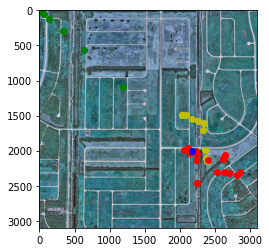

In [58]:
import importlib
importlib.reload(sherlock)
grid=sherlock.matchSorter(a,b,c)
print(grid)

In [60]:
import importlib
importlib.reload(sherlock)
point=sherlock.main()
print(point)

KeyboardInterrupt: 